# 初始化

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../')  # 返回notebook的上一级目录
# sys.path.append('E:\GitHub\QA-abstract-and-reasoning')  # 效果同上

In [2]:
# 在google colab运行则执行以下代码
try:
    from google.colab import drive
    drive_path = '/content/drive'
    working_path = drive_path + "/My Drive/QA" # 工作路径
    drive.mount(drive_path)
    os.chdir(working_path)
    sys.path.append(working_path)  # 环境变量
    print("current working directory: ", os.getcwd())
    
    # %tensorflow_version 仅存在于 Colab
    %tensorflow_version 2.x
    print("run notebook in colab")
except:
    print("no colab")

no colab


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
np.set_printoptions(suppress=True)
from utils.plot import plot_attention
from utils.saveLoader import *
from utils.config import *
from layers import *
from preprocess import Preprocess
from gensim.models.word2vec import LineSentence, Word2Vec
import tensorflow as tf
# from model_layer import seq2seq_model
import time
tf.__version__

'2.0.0'

[限制gpu内存增长](https://tensorflow.google.cn/guide/gpu#limiting_gpu_memory_growth)

In [4]:
from utils.config_gpu import config_gpu
config_gpu()

1 Physical GPUs, 1 Logical GPUs


## 加载数据

In [5]:
train_x,train_y,test_x = load_train_dataset()  # 数据集
vocab,vocab_reversed = load_vocab(VOCAB_PAD)  # vocab
embedding_matrix = np.loadtxt(EMBEDDING_MATRIX_PAD)  # 预训练层

## 设置参数

In [6]:
params = {}
params["vocab_size"] = len(vocab)
params["max_enc_len"] = train_x.shape[1]  # 260
params["max_dec_len"] = train_y.shape[1]  # 33
params["embed_size"] = embedding_matrix.shape[1]
params["enc_units"] = 256
params["attn_units"] = 10
params["dec_units"] = params["enc_units"]
params["batch_size"] = 32
params["epochs"] = 2
print(params)

{'vocab_size': 32566, 'max_enc_len': 260, 'max_dec_len': 33, 'embed_size': 300, 'enc_units': 256, 'attn_units': 10, 'dec_units': 256, 'batch_size': 32, 'epochs': 2}


## 构建训练集

In [7]:
# 取部分数据进行训练
# sample_num=64
sample_num = train_x.shape[0]
dataset = tf.data.Dataset.from_tensor_slices((train_x[:sample_num], train_y[:sample_num])).shuffle(params["batch_size"]*2+1)
dataset = dataset.batch(params["batch_size"], drop_remainder=True)

In [8]:
steps_per_epoch = sample_num//params["batch_size"]

## 构建模型

In [12]:
from seq2seq import *
model=Seq2Seq(params)

## 保存点设置

In [13]:
from utils.config import CKPT_DIR, CKPT_PREFIX
from utils.saveLoader import del_all_files_of_dir
del_all_files_of_dir(CKPT_DIR)
ckpt = tf.train.Checkpoint(Seq2Seq=model)
ckpt_manager = tf.train.CheckpointManager(ckpt, CKPT_DIR, max_to_keep=5)

there no files in this path


In [14]:

ckpt.restore(ckpt_manager.latest_checkpoint)
print("Model restored")

Model restored


## 训练

[SparseCategoricalCrossentropy](https://tensorflow.google.cn/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)

In [15]:
optimizer = tf.keras.optimizers.Adam(name='Adam',learning_rate=0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

pad_index=vocab['<PAD>']
unk_index=vocab['<UNK>']

def loss_function(real, pred):
    pad_mask = tf.math.equal(real, pad_index)
    unk_mask = tf.math.equal(real, unk_index)
    # <PAD> 和 <UNK> 的损失都不算
    mask = tf.math.logical_not(tf.math.logical_or(pad_mask,unk_mask))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)
    # return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
# 调试train_step()
# inp, targ = next(iter(dataset))
# pad_index=vocab['<PAD>']
# unk_index=vocab['<UNK>']
# enc_output, enc_hidden = model.call_encoder(inp)
# dec_hidden = enc_hidden
# dec_input = tf.expand_dims([vocab['<START>']] * params["batch_size"], 1)
# predictions, _ = model(dec_input, dec_hidden, enc_output, targ)

In [16]:
@tf.function
def train_step(inp, targ):
    pad_index=vocab['<PAD>']
    unk_index=vocab['<UNK>']
    loss = 0
    
    with tf.GradientTape() as tape:
        # 1. 构建encoder
        enc_output, enc_hidden = model.call_encoder(inp)
        # 2. 复制
        dec_hidden = enc_hidden
        # 3. <START> * BATCH_SIZE 
        dec_input = tf.expand_dims([vocab['<START>']] * params["batch_size"], 1)
        
        # 逐个预测序列
        predictions, _ = model(dec_input, dec_hidden, enc_output, targ)
        
        batch_loss = loss_function(targ[:, 1:], predictions)

        variables = model.encoder.trainable_variables + model.decoder.trainable_variables+ model.attention.trainable_variables
    
        gradients = tape.gradient(batch_loss, variables)

        optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss

In [17]:
epochs = params["epochs"]
# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
    
for epoch in range(epochs):
    start = time.time()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch+1)):
        batch_loss = train_step(inp, targ)
        total_loss += batch_loss

        if batch % 1 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.9748
Epoch 1 Batch 1 Loss 6.3068
Epoch 1 Batch 2 Loss 5.2856
Epoch 1 Batch 3 Loss 5.6969
Epoch 1 Batch 4 Loss 5.5998
Epoch 1 Batch 5 Loss 5.7948
Epoch 1 Batch 6 Loss 4.0068
Epoch 1 Batch 7 Loss 4.8437
Epoch 1 Batch 8 Loss 4.1494
Epoch 1 Batch 9 Loss 4.8610
Epoch 1 Batch 10 Loss 4.2249
Epoch 1 Batch 11 Loss 3.5277
Epoch 1 Batch 12 Loss 3.3266
Epoch 1 Batch 13 Loss 2.4634
Epoch 1 Batch 14 Loss 2.2345
Epoch 1 Batch 15 Loss 3.2764
Epoch 1 Batch 16 Loss 2.7978
Epoch 1 Batch 17 Loss 2.6513
Epoch 1 Batch 18 Loss 2.0814
Epoch 1 Batch 19 Loss 3.2465
Epoch 1 Batch 20 Loss 4.1165
Epoch 1 Batch 21 Loss 3.5698
Epoch 1 Batch 22 Loss 2.7225
Epoch 1 Batch 23 Loss 3.1314
Epoch 1 Batch 24 Loss 2.6006
Epoch 1 Batch 25 Loss 2.4615
Epoch 1 Batch 26 Loss 2.3426
Epoch 1 Batch 27 Loss 3.4894
Epoch 1 Batch 28 Loss 3.2427
Epoch 1 Batch 29 Loss 3.5756
Epoch 1 Batch 30 Loss 2.7058
Epoch 1 Batch 31 Loss 3.3102
Epoch 1 Batch 32 Loss 2.4620
Epoch 1 Batch 33 Loss 2.8100
Epoch 1 Batch 34 Loss 1.

Epoch 1 Batch 277 Loss 2.1417
Epoch 1 Batch 278 Loss 2.4971
Epoch 1 Batch 279 Loss 2.2793
Epoch 1 Batch 280 Loss 2.5576
Epoch 1 Batch 281 Loss 3.0865
Epoch 1 Batch 282 Loss 2.5766
Epoch 1 Batch 283 Loss 2.5527
Epoch 1 Batch 284 Loss 2.0635
Epoch 1 Batch 285 Loss 2.2774
Epoch 1 Batch 286 Loss 2.1888
Epoch 1 Batch 287 Loss 1.8481
Epoch 1 Batch 288 Loss 2.4249
Epoch 1 Batch 289 Loss 2.6497
Epoch 1 Batch 290 Loss 2.2709
Epoch 1 Batch 291 Loss 2.1527
Epoch 1 Batch 292 Loss 1.5704
Epoch 1 Batch 293 Loss 2.3197
Epoch 1 Batch 294 Loss 2.1963
Epoch 1 Batch 295 Loss 2.2006
Epoch 1 Batch 296 Loss 1.8862
Epoch 1 Batch 297 Loss 1.8809
Epoch 1 Batch 298 Loss 2.1006
Epoch 1 Batch 299 Loss 2.0901
Epoch 1 Batch 300 Loss 2.2854
Epoch 1 Batch 301 Loss 2.1871
Epoch 1 Batch 302 Loss 2.1028
Epoch 1 Batch 303 Loss 1.9281
Epoch 1 Batch 304 Loss 2.2708
Epoch 1 Batch 305 Loss 2.1611
Epoch 1 Batch 306 Loss 2.3706
Epoch 1 Batch 307 Loss 2.4295
Epoch 1 Batch 308 Loss 2.0004
Epoch 1 Batch 309 Loss 3.0357
Epoch 1 Ba

Epoch 1 Batch 552 Loss 1.8525
Epoch 1 Batch 553 Loss 2.3659
Epoch 1 Batch 554 Loss 2.1962
Epoch 1 Batch 555 Loss 2.3052
Epoch 1 Batch 556 Loss 2.2576
Epoch 1 Batch 557 Loss 1.6550
Epoch 1 Batch 558 Loss 2.0800
Epoch 1 Batch 559 Loss 2.0328
Epoch 1 Batch 560 Loss 2.1066
Epoch 1 Batch 561 Loss 2.2905
Epoch 1 Batch 562 Loss 2.2658
Epoch 1 Batch 563 Loss 2.0765
Epoch 1 Batch 564 Loss 2.2018
Epoch 1 Batch 565 Loss 2.1462
Epoch 1 Batch 566 Loss 1.7480
Epoch 1 Batch 567 Loss 2.2310
Epoch 1 Batch 568 Loss 2.2628
Epoch 1 Batch 569 Loss 1.9961
Epoch 1 Batch 570 Loss 2.0219
Epoch 1 Batch 571 Loss 1.6372
Epoch 1 Batch 572 Loss 1.5511
Epoch 1 Batch 573 Loss 2.0662
Epoch 1 Batch 574 Loss 2.0943
Epoch 1 Batch 575 Loss 2.4267
Epoch 1 Batch 576 Loss 2.6431
Epoch 1 Batch 577 Loss 2.3985
Epoch 1 Batch 578 Loss 2.2124
Epoch 1 Batch 579 Loss 1.8946
Epoch 1 Batch 580 Loss 2.3972
Epoch 1 Batch 581 Loss 2.5207
Epoch 1 Batch 582 Loss 2.0755
Epoch 1 Batch 583 Loss 1.9613
Epoch 1 Batch 584 Loss 1.8972
Epoch 1 Ba

Epoch 1 Batch 826 Loss 2.1212
Epoch 1 Batch 827 Loss 1.8558
Epoch 1 Batch 828 Loss 2.0776
Epoch 1 Batch 829 Loss 2.3757
Epoch 1 Batch 830 Loss 2.9994
Epoch 1 Batch 831 Loss 2.0989
Epoch 1 Batch 832 Loss 2.4157
Epoch 1 Batch 833 Loss 1.9746
Epoch 1 Batch 834 Loss 1.6071
Epoch 1 Batch 835 Loss 2.4467
Epoch 1 Batch 836 Loss 1.7554
Epoch 1 Batch 837 Loss 2.0316
Epoch 1 Batch 838 Loss 1.7289
Epoch 1 Batch 839 Loss 1.9930
Epoch 1 Batch 840 Loss 2.4718
Epoch 1 Batch 841 Loss 2.5023
Epoch 1 Batch 842 Loss 2.0485
Epoch 1 Batch 843 Loss 2.0092
Epoch 1 Batch 844 Loss 2.0314
Epoch 1 Batch 845 Loss 2.0255
Epoch 1 Batch 846 Loss 2.0997
Epoch 1 Batch 847 Loss 1.7341
Epoch 1 Batch 848 Loss 2.0275
Epoch 1 Batch 849 Loss 1.8715
Epoch 1 Batch 850 Loss 2.1985
Epoch 1 Batch 851 Loss 1.7941
Epoch 1 Batch 852 Loss 2.3432
Epoch 1 Batch 853 Loss 2.4601
Epoch 1 Batch 854 Loss 2.2956
Epoch 1 Batch 855 Loss 1.6971
Epoch 1 Batch 856 Loss 1.6715
Epoch 1 Batch 857 Loss 1.8224
Epoch 1 Batch 858 Loss 2.0515
Epoch 1 Ba

Epoch 1 Batch 1097 Loss 1.9514
Epoch 1 Batch 1098 Loss 2.1116
Epoch 1 Batch 1099 Loss 2.5544
Epoch 1 Batch 1100 Loss 1.8820
Epoch 1 Batch 1101 Loss 2.2018
Epoch 1 Batch 1102 Loss 1.8250
Epoch 1 Batch 1103 Loss 2.1760
Epoch 1 Batch 1104 Loss 1.8418
Epoch 1 Batch 1105 Loss 2.2748
Epoch 1 Batch 1106 Loss 2.4008
Epoch 1 Batch 1107 Loss 2.1038
Epoch 1 Batch 1108 Loss 2.2074
Epoch 1 Batch 1109 Loss 2.4590
Epoch 1 Batch 1110 Loss 2.3036
Epoch 1 Batch 1111 Loss 1.9071
Epoch 1 Batch 1112 Loss 1.8184
Epoch 1 Batch 1113 Loss 1.7409
Epoch 1 Batch 1114 Loss 1.7913
Epoch 1 Batch 1115 Loss 2.3523
Epoch 1 Batch 1116 Loss 1.9769
Epoch 1 Batch 1117 Loss 1.9477
Epoch 1 Batch 1118 Loss 2.2411
Epoch 1 Batch 1119 Loss 1.9220
Epoch 1 Batch 1120 Loss 2.2216
Epoch 1 Batch 1121 Loss 2.6205
Epoch 1 Batch 1122 Loss 2.3379
Epoch 1 Batch 1123 Loss 1.8189
Epoch 1 Batch 1124 Loss 1.9431
Epoch 1 Batch 1125 Loss 2.6112
Epoch 1 Batch 1126 Loss 2.0671
Epoch 1 Batch 1127 Loss 2.3646
Epoch 1 Batch 1128 Loss 2.1319
Epoch 1 

Epoch 1 Batch 1362 Loss 1.7904
Epoch 1 Batch 1363 Loss 1.9410
Epoch 1 Batch 1364 Loss 1.9698
Epoch 1 Batch 1365 Loss 1.8498
Epoch 1 Batch 1366 Loss 1.3814
Epoch 1 Batch 1367 Loss 1.9299
Epoch 1 Batch 1368 Loss 1.8727
Epoch 1 Batch 1369 Loss 2.2228
Epoch 1 Batch 1370 Loss 1.9084
Epoch 1 Batch 1371 Loss 1.5553
Epoch 1 Batch 1372 Loss 1.7523
Epoch 1 Batch 1373 Loss 1.9314
Epoch 1 Batch 1374 Loss 1.8457
Epoch 1 Batch 1375 Loss 1.9347
Epoch 1 Batch 1376 Loss 1.6482
Epoch 1 Batch 1377 Loss 1.5274
Epoch 1 Batch 1378 Loss 1.9787
Epoch 1 Batch 1379 Loss 2.2462
Epoch 1 Batch 1380 Loss 1.8603
Epoch 1 Batch 1381 Loss 2.2549
Epoch 1 Batch 1382 Loss 1.8865
Epoch 1 Batch 1383 Loss 1.8384
Epoch 1 Batch 1384 Loss 1.9382
Epoch 1 Batch 1385 Loss 2.1904
Epoch 1 Batch 1386 Loss 1.8501
Epoch 1 Batch 1387 Loss 1.7880
Epoch 1 Batch 1388 Loss 1.8334
Epoch 1 Batch 1389 Loss 2.2105
Epoch 1 Batch 1390 Loss 1.9402
Epoch 1 Batch 1391 Loss 1.9529
Epoch 1 Batch 1392 Loss 1.8810
Epoch 1 Batch 1393 Loss 2.4910
Epoch 1 

Epoch 1 Batch 1627 Loss 2.0381
Epoch 1 Batch 1628 Loss 2.4309
Epoch 1 Batch 1629 Loss 3.0875
Epoch 1 Batch 1630 Loss 2.5178
Epoch 1 Batch 1631 Loss 2.3453
Epoch 1 Batch 1632 Loss 2.0195
Epoch 1 Batch 1633 Loss 2.3296
Epoch 1 Batch 1634 Loss 1.9414
Epoch 1 Batch 1635 Loss 2.3559
Epoch 1 Batch 1636 Loss 2.1464
Epoch 1 Batch 1637 Loss 1.8822
Epoch 1 Batch 1638 Loss 1.4894
Epoch 1 Batch 1639 Loss 2.2766
Epoch 1 Batch 1640 Loss 2.4482
Epoch 1 Batch 1641 Loss 2.0682
Epoch 1 Batch 1642 Loss 1.9103
Epoch 1 Batch 1643 Loss 2.0642
Epoch 1 Batch 1644 Loss 1.5936
Epoch 1 Batch 1645 Loss 1.5459
Epoch 1 Batch 1646 Loss 1.2384
Epoch 1 Batch 1647 Loss 1.3248
Epoch 1 Batch 1648 Loss 1.7437
Epoch 1 Batch 1649 Loss 1.9454
Epoch 1 Batch 1650 Loss 1.9406
Epoch 1 Batch 1651 Loss 2.3671
Epoch 1 Batch 1652 Loss 1.8873
Epoch 1 Batch 1653 Loss 1.9898
Epoch 1 Batch 1654 Loss 1.5089
Epoch 1 Batch 1655 Loss 1.6784
Epoch 1 Batch 1656 Loss 2.5173
Epoch 1 Batch 1657 Loss 2.3479
Epoch 1 Batch 1658 Loss 2.1015
Epoch 1 

Epoch 1 Batch 1891 Loss 1.4927
Epoch 1 Batch 1892 Loss 1.7133
Epoch 1 Batch 1893 Loss 1.4191
Epoch 1 Batch 1894 Loss 1.7326
Epoch 1 Batch 1895 Loss 1.7665
Epoch 1 Batch 1896 Loss 1.6516
Epoch 1 Batch 1897 Loss 1.6096
Epoch 1 Batch 1898 Loss 2.3039
Epoch 1 Batch 1899 Loss 1.9149
Epoch 1 Batch 1900 Loss 1.6664
Epoch 1 Batch 1901 Loss 2.2313
Epoch 1 Batch 1902 Loss 2.2011
Epoch 1 Batch 1903 Loss 2.3241
Epoch 1 Batch 1904 Loss 2.7000
Epoch 1 Batch 1905 Loss 1.9077
Epoch 1 Batch 1906 Loss 2.3542
Epoch 1 Batch 1907 Loss 2.2012
Epoch 1 Batch 1908 Loss 2.6784
Epoch 1 Batch 1909 Loss 2.0925
Epoch 1 Batch 1910 Loss 2.3479
Epoch 1 Batch 1911 Loss 2.1575
Epoch 1 Batch 1912 Loss 2.6232
Epoch 1 Batch 1913 Loss 2.1465
Epoch 1 Batch 1914 Loss 2.2676
Epoch 1 Batch 1915 Loss 2.6808
Epoch 1 Batch 1916 Loss 2.2956
Epoch 1 Batch 1917 Loss 2.1460
Epoch 1 Batch 1918 Loss 1.9070
Epoch 1 Batch 1919 Loss 1.6421
Epoch 1 Batch 1920 Loss 1.5645
Epoch 1 Batch 1921 Loss 1.9378
Epoch 1 Batch 1922 Loss 1.9983
Epoch 1 

Epoch 1 Batch 2156 Loss 2.5878
Epoch 1 Batch 2157 Loss 2.7671
Epoch 1 Batch 2158 Loss 2.2817
Epoch 1 Batch 2159 Loss 2.2082
Epoch 1 Batch 2160 Loss 1.9927
Epoch 1 Batch 2161 Loss 1.9696
Epoch 1 Batch 2162 Loss 2.3299
Epoch 1 Batch 2163 Loss 2.3940
Epoch 1 Batch 2164 Loss 1.9304
Epoch 1 Batch 2165 Loss 1.9813
Epoch 1 Batch 2166 Loss 2.0056
Epoch 1 Batch 2167 Loss 2.4268
Epoch 1 Batch 2168 Loss 1.3391
Epoch 1 Batch 2169 Loss 1.7596
Epoch 1 Batch 2170 Loss 1.7103
Epoch 1 Batch 2171 Loss 1.9348
Epoch 1 Batch 2172 Loss 1.7945
Epoch 1 Batch 2173 Loss 1.8460
Epoch 1 Batch 2174 Loss 1.6604
Epoch 1 Batch 2175 Loss 1.7494
Epoch 1 Batch 2176 Loss 1.9226
Epoch 1 Batch 2177 Loss 2.3602
Epoch 1 Batch 2178 Loss 2.0529
Epoch 1 Batch 2179 Loss 2.5452
Epoch 1 Batch 2180 Loss 2.4591
Epoch 1 Batch 2181 Loss 2.2445
Epoch 1 Batch 2182 Loss 2.1897
Epoch 1 Batch 2183 Loss 1.6442
Epoch 1 Batch 2184 Loss 1.8325
Epoch 1 Batch 2185 Loss 1.9808
Epoch 1 Batch 2186 Loss 2.3138
Epoch 1 Batch 2187 Loss 2.0417
Epoch 1 

Epoch 1 Batch 2421 Loss 1.1731
Epoch 1 Batch 2422 Loss 1.3447
Epoch 1 Batch 2423 Loss 1.6988
Epoch 1 Batch 2424 Loss 1.6421
Epoch 1 Batch 2425 Loss 2.0204
Epoch 1 Batch 2426 Loss 2.1050
Epoch 1 Batch 2427 Loss 2.2699
Epoch 1 Batch 2428 Loss 1.7757
Epoch 1 Batch 2429 Loss 1.3712
Epoch 1 Batch 2430 Loss 1.3357
Epoch 1 Batch 2431 Loss 1.7401
Epoch 1 Batch 2432 Loss 1.4299
Epoch 1 Batch 2433 Loss 1.6912
Epoch 1 Batch 2434 Loss 1.5623
Epoch 1 Batch 2435 Loss 1.4666
Epoch 1 Batch 2436 Loss 1.5178
Epoch 1 Batch 2437 Loss 1.5787
Epoch 1 Batch 2438 Loss 1.6110
Epoch 1 Batch 2439 Loss 1.8370
Epoch 1 Batch 2440 Loss 1.4826
Epoch 1 Batch 2441 Loss 1.2456
Epoch 1 Batch 2442 Loss 1.3944
Epoch 1 Batch 2443 Loss 1.3060
Epoch 1 Batch 2444 Loss 1.5318
Epoch 1 Batch 2445 Loss 1.7917
Epoch 1 Batch 2446 Loss 2.0239
Epoch 1 Batch 2447 Loss 1.3499
Epoch 1 Batch 2448 Loss 1.1558
Epoch 1 Batch 2449 Loss 1.3024
Epoch 1 Batch 2450 Loss 1.8391
Epoch 1 Batch 2451 Loss 2.2103
Epoch 1 Batch 2452 Loss 2.0204
Epoch 1 

Epoch 2 Batch 100 Loss 2.3936
Epoch 2 Batch 101 Loss 2.3195
Epoch 2 Batch 102 Loss 1.7828
Epoch 2 Batch 103 Loss 1.8159
Epoch 2 Batch 104 Loss 2.1964
Epoch 2 Batch 105 Loss 2.3287
Epoch 2 Batch 106 Loss 1.9103
Epoch 2 Batch 107 Loss 2.2531
Epoch 2 Batch 108 Loss 2.3847
Epoch 2 Batch 109 Loss 1.9533
Epoch 2 Batch 110 Loss 1.5149
Epoch 2 Batch 111 Loss 1.2306
Epoch 2 Batch 112 Loss 1.3896
Epoch 2 Batch 113 Loss 2.1623
Epoch 2 Batch 114 Loss 1.7363
Epoch 2 Batch 115 Loss 1.5454
Epoch 2 Batch 116 Loss 1.9604
Epoch 2 Batch 117 Loss 1.5932
Epoch 2 Batch 118 Loss 2.1242
Epoch 2 Batch 119 Loss 1.9119
Epoch 2 Batch 120 Loss 1.4624
Epoch 2 Batch 121 Loss 1.2976
Epoch 2 Batch 122 Loss 2.0307
Epoch 2 Batch 123 Loss 1.6156
Epoch 2 Batch 124 Loss 1.8505
Epoch 2 Batch 125 Loss 1.5033
Epoch 2 Batch 126 Loss 1.4752
Epoch 2 Batch 127 Loss 1.8315
Epoch 2 Batch 128 Loss 1.3561
Epoch 2 Batch 129 Loss 1.6398
Epoch 2 Batch 130 Loss 1.6611
Epoch 2 Batch 131 Loss 1.5822
Epoch 2 Batch 132 Loss 1.8288
Epoch 2 Ba

Epoch 2 Batch 375 Loss 1.4967
Epoch 2 Batch 376 Loss 1.3759
Epoch 2 Batch 377 Loss 1.4877
Epoch 2 Batch 378 Loss 1.8386
Epoch 2 Batch 379 Loss 1.2301
Epoch 2 Batch 380 Loss 1.3078
Epoch 2 Batch 381 Loss 1.2047
Epoch 2 Batch 382 Loss 1.4628
Epoch 2 Batch 383 Loss 1.9474
Epoch 2 Batch 384 Loss 1.8416
Epoch 2 Batch 385 Loss 1.3272
Epoch 2 Batch 386 Loss 1.4036
Epoch 2 Batch 387 Loss 1.7270
Epoch 2 Batch 388 Loss 2.1856
Epoch 2 Batch 389 Loss 1.9213
Epoch 2 Batch 390 Loss 1.8738
Epoch 2 Batch 391 Loss 1.5980
Epoch 2 Batch 392 Loss 1.6689
Epoch 2 Batch 393 Loss 1.7502
Epoch 2 Batch 394 Loss 1.5422
Epoch 2 Batch 395 Loss 1.2696
Epoch 2 Batch 396 Loss 1.4181
Epoch 2 Batch 397 Loss 1.5015
Epoch 2 Batch 398 Loss 1.7623
Epoch 2 Batch 399 Loss 1.5451
Epoch 2 Batch 400 Loss 1.6928
Epoch 2 Batch 401 Loss 1.7104
Epoch 2 Batch 402 Loss 1.0621
Epoch 2 Batch 403 Loss 1.5584
Epoch 2 Batch 404 Loss 1.6678
Epoch 2 Batch 405 Loss 1.5503
Epoch 2 Batch 406 Loss 1.5830
Epoch 2 Batch 407 Loss 1.8535
Epoch 2 Ba

Epoch 2 Batch 649 Loss 1.6462
Epoch 2 Batch 650 Loss 1.8010
Epoch 2 Batch 651 Loss 1.8374
Epoch 2 Batch 652 Loss 1.7003
Epoch 2 Batch 653 Loss 1.8608
Epoch 2 Batch 654 Loss 1.7215
Epoch 2 Batch 655 Loss 2.1861
Epoch 2 Batch 656 Loss 2.0291
Epoch 2 Batch 657 Loss 2.3905
Epoch 2 Batch 658 Loss 1.4835
Epoch 2 Batch 659 Loss 1.8437
Epoch 2 Batch 660 Loss 1.7153
Epoch 2 Batch 661 Loss 2.0460
Epoch 2 Batch 662 Loss 2.0262
Epoch 2 Batch 663 Loss 1.8302
Epoch 2 Batch 664 Loss 1.7402
Epoch 2 Batch 665 Loss 2.0708
Epoch 2 Batch 666 Loss 1.5149
Epoch 2 Batch 667 Loss 1.9224
Epoch 2 Batch 668 Loss 1.9417
Epoch 2 Batch 669 Loss 1.8296
Epoch 2 Batch 670 Loss 1.9407
Epoch 2 Batch 671 Loss 1.3248
Epoch 2 Batch 672 Loss 1.6455
Epoch 2 Batch 673 Loss 1.7130
Epoch 2 Batch 674 Loss 1.8253
Epoch 2 Batch 675 Loss 1.5493
Epoch 2 Batch 676 Loss 1.7108
Epoch 2 Batch 677 Loss 1.6497
Epoch 2 Batch 678 Loss 1.8536
Epoch 2 Batch 679 Loss 2.0250
Epoch 2 Batch 680 Loss 1.6541
Epoch 2 Batch 681 Loss 1.7836
Epoch 2 Ba

Epoch 2 Batch 923 Loss 1.6673
Epoch 2 Batch 924 Loss 1.8398
Epoch 2 Batch 925 Loss 1.9625
Epoch 2 Batch 926 Loss 1.9772
Epoch 2 Batch 927 Loss 2.1283
Epoch 2 Batch 928 Loss 1.9353
Epoch 2 Batch 929 Loss 2.1900
Epoch 2 Batch 930 Loss 2.2311
Epoch 2 Batch 931 Loss 1.6178
Epoch 2 Batch 932 Loss 1.7143
Epoch 2 Batch 933 Loss 2.3842
Epoch 2 Batch 934 Loss 2.4419
Epoch 2 Batch 935 Loss 2.3827
Epoch 2 Batch 936 Loss 2.1342
Epoch 2 Batch 937 Loss 2.1670
Epoch 2 Batch 938 Loss 1.8764
Epoch 2 Batch 939 Loss 1.8451
Epoch 2 Batch 940 Loss 1.5721
Epoch 2 Batch 941 Loss 1.5781
Epoch 2 Batch 942 Loss 1.2782
Epoch 2 Batch 943 Loss 1.3947
Epoch 2 Batch 944 Loss 1.6065
Epoch 2 Batch 945 Loss 1.8218
Epoch 2 Batch 946 Loss 2.0843
Epoch 2 Batch 947 Loss 1.9547
Epoch 2 Batch 948 Loss 1.4983
Epoch 2 Batch 949 Loss 1.9014
Epoch 2 Batch 950 Loss 1.8174
Epoch 2 Batch 951 Loss 1.8430
Epoch 2 Batch 952 Loss 1.7935
Epoch 2 Batch 953 Loss 1.8848
Epoch 2 Batch 954 Loss 1.6982
Epoch 2 Batch 955 Loss 1.7125
Epoch 2 Ba

Epoch 2 Batch 1190 Loss 1.7528
Epoch 2 Batch 1191 Loss 1.5955
Epoch 2 Batch 1192 Loss 1.8334
Epoch 2 Batch 1193 Loss 2.0395
Epoch 2 Batch 1194 Loss 1.5605
Epoch 2 Batch 1195 Loss 1.8096
Epoch 2 Batch 1196 Loss 1.7214
Epoch 2 Batch 1197 Loss 1.7850
Epoch 2 Batch 1198 Loss 1.3455
Epoch 2 Batch 1199 Loss 1.4999
Epoch 2 Batch 1200 Loss 1.5413
Epoch 2 Batch 1201 Loss 1.5179
Epoch 2 Batch 1202 Loss 2.0812
Epoch 2 Batch 1203 Loss 1.5796
Epoch 2 Batch 1204 Loss 1.2040
Epoch 2 Batch 1205 Loss 1.8587
Epoch 2 Batch 1206 Loss 1.2200
Epoch 2 Batch 1207 Loss 1.6254
Epoch 2 Batch 1208 Loss 1.8285
Epoch 2 Batch 1209 Loss 1.7545
Epoch 2 Batch 1210 Loss 1.6746
Epoch 2 Batch 1211 Loss 1.9319
Epoch 2 Batch 1212 Loss 2.0877
Epoch 2 Batch 1213 Loss 1.8622
Epoch 2 Batch 1214 Loss 2.0177
Epoch 2 Batch 1215 Loss 1.6217
Epoch 2 Batch 1216 Loss 1.8074
Epoch 2 Batch 1217 Loss 1.4569
Epoch 2 Batch 1218 Loss 1.6666
Epoch 2 Batch 1219 Loss 1.6782
Epoch 2 Batch 1220 Loss 2.0254
Epoch 2 Batch 1221 Loss 1.5316
Epoch 2 

Epoch 2 Batch 1455 Loss 1.6142
Epoch 2 Batch 1456 Loss 1.8257
Epoch 2 Batch 1457 Loss 1.4931
Epoch 2 Batch 1458 Loss 1.1862
Epoch 2 Batch 1459 Loss 1.1145
Epoch 2 Batch 1460 Loss 1.2765
Epoch 2 Batch 1461 Loss 1.0143
Epoch 2 Batch 1462 Loss 1.0054
Epoch 2 Batch 1463 Loss 1.7929
Epoch 2 Batch 1464 Loss 1.1978
Epoch 2 Batch 1465 Loss 1.5673
Epoch 2 Batch 1466 Loss 1.4462
Epoch 2 Batch 1467 Loss 2.0491
Epoch 2 Batch 1468 Loss 2.0292
Epoch 2 Batch 1469 Loss 2.0575
Epoch 2 Batch 1470 Loss 1.3817
Epoch 2 Batch 1471 Loss 1.9084
Epoch 2 Batch 1472 Loss 2.1215
Epoch 2 Batch 1473 Loss 1.4038
Epoch 2 Batch 1474 Loss 1.6969
Epoch 2 Batch 1475 Loss 1.6857
Epoch 2 Batch 1476 Loss 1.8511
Epoch 2 Batch 1477 Loss 2.0597
Epoch 2 Batch 1478 Loss 1.4801
Epoch 2 Batch 1479 Loss 1.6080
Epoch 2 Batch 1480 Loss 1.3468
Epoch 2 Batch 1481 Loss 1.5620
Epoch 2 Batch 1482 Loss 1.7721
Epoch 2 Batch 1483 Loss 1.8492
Epoch 2 Batch 1484 Loss 1.5591
Epoch 2 Batch 1485 Loss 1.4651
Epoch 2 Batch 1486 Loss 1.1129
Epoch 2 

Epoch 2 Batch 1720 Loss 1.7597
Epoch 2 Batch 1721 Loss 1.9094
Epoch 2 Batch 1722 Loss 1.6941
Epoch 2 Batch 1723 Loss 1.3135
Epoch 2 Batch 1724 Loss 1.4657
Epoch 2 Batch 1725 Loss 2.0083
Epoch 2 Batch 1726 Loss 1.7255
Epoch 2 Batch 1727 Loss 2.1762
Epoch 2 Batch 1728 Loss 1.3985
Epoch 2 Batch 1729 Loss 2.2558
Epoch 2 Batch 1730 Loss 1.8317
Epoch 2 Batch 1731 Loss 1.7828
Epoch 2 Batch 1732 Loss 1.5872
Epoch 2 Batch 1733 Loss 1.5347
Epoch 2 Batch 1734 Loss 1.2665
Epoch 2 Batch 1735 Loss 1.4794
Epoch 2 Batch 1736 Loss 1.8928
Epoch 2 Batch 1737 Loss 2.2235
Epoch 2 Batch 1738 Loss 2.1511
Epoch 2 Batch 1739 Loss 1.5051
Epoch 2 Batch 1740 Loss 1.9331
Epoch 2 Batch 1741 Loss 1.8718
Epoch 2 Batch 1742 Loss 1.4493
Epoch 2 Batch 1743 Loss 1.5516
Epoch 2 Batch 1744 Loss 1.0387
Epoch 2 Batch 1745 Loss 1.3702
Epoch 2 Batch 1746 Loss 1.8786
Epoch 2 Batch 1747 Loss 1.3677
Epoch 2 Batch 1748 Loss 1.9501
Epoch 2 Batch 1749 Loss 1.8854
Epoch 2 Batch 1750 Loss 1.4524
Epoch 2 Batch 1751 Loss 2.0367
Epoch 2 

Epoch 2 Batch 1986 Loss 2.0247
Epoch 2 Batch 1987 Loss 2.0269
Epoch 2 Batch 1988 Loss 1.5830
Epoch 2 Batch 1989 Loss 1.7218
Epoch 2 Batch 1990 Loss 1.4834
Epoch 2 Batch 1991 Loss 1.6328
Epoch 2 Batch 1992 Loss 1.5552
Epoch 2 Batch 1993 Loss 1.5965
Epoch 2 Batch 1994 Loss 1.8346
Epoch 2 Batch 1995 Loss 1.6753
Epoch 2 Batch 1996 Loss 1.7879
Epoch 2 Batch 1997 Loss 1.5889
Epoch 2 Batch 1998 Loss 1.7383
Epoch 2 Batch 1999 Loss 1.7541
Epoch 2 Batch 2000 Loss 1.9733
Epoch 2 Batch 2001 Loss 1.7354
Epoch 2 Batch 2002 Loss 2.3654
Epoch 2 Batch 2003 Loss 2.0196
Epoch 2 Batch 2004 Loss 2.1286
Epoch 2 Batch 2005 Loss 1.7934
Epoch 2 Batch 2006 Loss 2.0520
Epoch 2 Batch 2007 Loss 2.1426
Epoch 2 Batch 2008 Loss 1.4881
Epoch 2 Batch 2009 Loss 2.1750
Epoch 2 Batch 2010 Loss 2.2725
Epoch 2 Batch 2011 Loss 2.0345
Epoch 2 Batch 2012 Loss 1.8992
Epoch 2 Batch 2013 Loss 2.1203
Epoch 2 Batch 2014 Loss 1.4842
Epoch 2 Batch 2015 Loss 1.6385
Epoch 2 Batch 2016 Loss 1.3000
Epoch 2 Batch 2017 Loss 1.8198
Epoch 2 

Epoch 2 Batch 2251 Loss 1.6549
Epoch 2 Batch 2252 Loss 1.3086
Epoch 2 Batch 2253 Loss 1.9197
Epoch 2 Batch 2254 Loss 1.4056
Epoch 2 Batch 2255 Loss 1.4351
Epoch 2 Batch 2256 Loss 1.8914
Epoch 2 Batch 2257 Loss 1.7419
Epoch 2 Batch 2258 Loss 1.7202
Epoch 2 Batch 2259 Loss 1.7413
Epoch 2 Batch 2260 Loss 1.6415
Epoch 2 Batch 2261 Loss 1.8891
Epoch 2 Batch 2262 Loss 1.3178
Epoch 2 Batch 2263 Loss 1.7888
Epoch 2 Batch 2264 Loss 1.4017
Epoch 2 Batch 2265 Loss 1.5952
Epoch 2 Batch 2266 Loss 1.4479
Epoch 2 Batch 2267 Loss 1.6588
Epoch 2 Batch 2268 Loss 1.7328
Epoch 2 Batch 2269 Loss 1.2187
Epoch 2 Batch 2270 Loss 1.6975
Epoch 2 Batch 2271 Loss 1.6195
Epoch 2 Batch 2272 Loss 1.5666
Epoch 2 Batch 2273 Loss 1.7706
Epoch 2 Batch 2274 Loss 1.6348
Epoch 2 Batch 2275 Loss 1.7446
Epoch 2 Batch 2276 Loss 2.1587
Epoch 2 Batch 2277 Loss 1.7463
Epoch 2 Batch 2278 Loss 1.6967
Epoch 2 Batch 2279 Loss 1.4270
Epoch 2 Batch 2280 Loss 1.3905
Epoch 2 Batch 2281 Loss 1.5818
Epoch 2 Batch 2282 Loss 1.3984
Epoch 2 

Epoch 2 Batch 2517 Loss 1.2910
Epoch 2 Batch 2518 Loss 1.1626
Epoch 2 Batch 2519 Loss 2.0844
Epoch 2 Batch 2520 Loss 1.7096
Epoch 2 Batch 2521 Loss 1.7449
Epoch 2 Batch 2522 Loss 1.8362
Epoch 2 Batch 2523 Loss 1.7869
Epoch 2 Batch 2524 Loss 1.8777
Epoch 2 Batch 2525 Loss 1.6830
Epoch 2 Batch 2526 Loss 1.5908
Epoch 2 Batch 2527 Loss 2.3014
Epoch 2 Batch 2528 Loss 1.8916
Epoch 2 Batch 2529 Loss 2.0211
Epoch 2 Batch 2530 Loss 1.7027
Epoch 2 Batch 2531 Loss 1.6312
Epoch 2 Batch 2532 Loss 1.5231
Epoch 2 Batch 2533 Loss 1.3710
Epoch 2 Batch 2534 Loss 1.3560
Epoch 2 Batch 2535 Loss 1.7345
Epoch 2 Batch 2536 Loss 1.4188
Epoch 2 Batch 2537 Loss 1.2768
Epoch 2 Batch 2538 Loss 1.2969
Epoch 2 Batch 2539 Loss 1.8825
Epoch 2 Batch 2540 Loss 1.4253
Epoch 2 Batch 2541 Loss 1.4017
Epoch 2 Batch 2542 Loss 1.2193
Epoch 2 Batch 2543 Loss 1.4038
Epoch 2 Batch 2544 Loss 1.3100
Epoch 2 Batch 2545 Loss 1.6577
Epoch 2 Batch 2546 Loss 1.6178
Epoch 2 Batch 2547 Loss 1.6066
Epoch 2 Batch 2548 Loss 1.4903
Epoch 2 

## 载入模型

In [18]:
# 如果检查点存在，则恢复最新的检查点。
ckpt.restore(ckpt_manager.latest_checkpoint)
print("Model restored")

Model restored


In [19]:
def evaluate(model,inputs):
    attention_plot = np.zeros((params["max_dec_len"], params["max_enc_len"]))
    
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    
    hidden = [tf.zeros((1, params["enc_units"]))]
    enc_output, enc_hidden = model.encoder(inputs, hidden)

    dec_hidden = enc_hidden
    
    dec_input = tf.expand_dims([vocab['<START>']], 0)
    
    context_vector, _ = model.attention(dec_hidden, enc_output)

    for t in range(params["max_dec_len"]):
        
        context_vector, attention_weights = model.attention(dec_hidden, enc_output)
        
        predictions, dec_hidden = model.decoder(dec_input,
                                         dec_hidden,
                                         enc_output,
                                         context_vector)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()

        result += vocab_reversed[predicted_id] + ' '
        if vocab_reversed[predicted_id] == '<STOP>':
            return result, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, attention_plot

In [20]:
def translate(sentence):
    st = preproc.sentence_proc(sentence)
    sentence = preproc.sentence_proc_eval(sentence,params["max_enc_len"]-2,vocab)
    result, attention_plot = evaluate(model,sentence)

    print('Input: %s' % (st))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(st.split(' '))]
    plot_attention(attention_plot, st.split(' '), result.split(' '))

In [21]:
sentence = '方向机重，助力泵，方向机都换了还是一样'
preproc = Preprocess()
preproc.sentence_proc(sentence)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Light\AppData\Local\Temp\jieba.cache
Loading model cost 0.678 seconds.
Prefix dict has been built succesfully.


'方向机 重 助力 泵 方向机 都 换'

In [22]:
# import matplotlib as mpl
# mpl.rcParams['font.family'] = 'STSong'  # 显示中文

Input: 方向机 重 助力 泵 方向机 都 换
Predicted translation: 方向机 助力 泵 <STOP> 


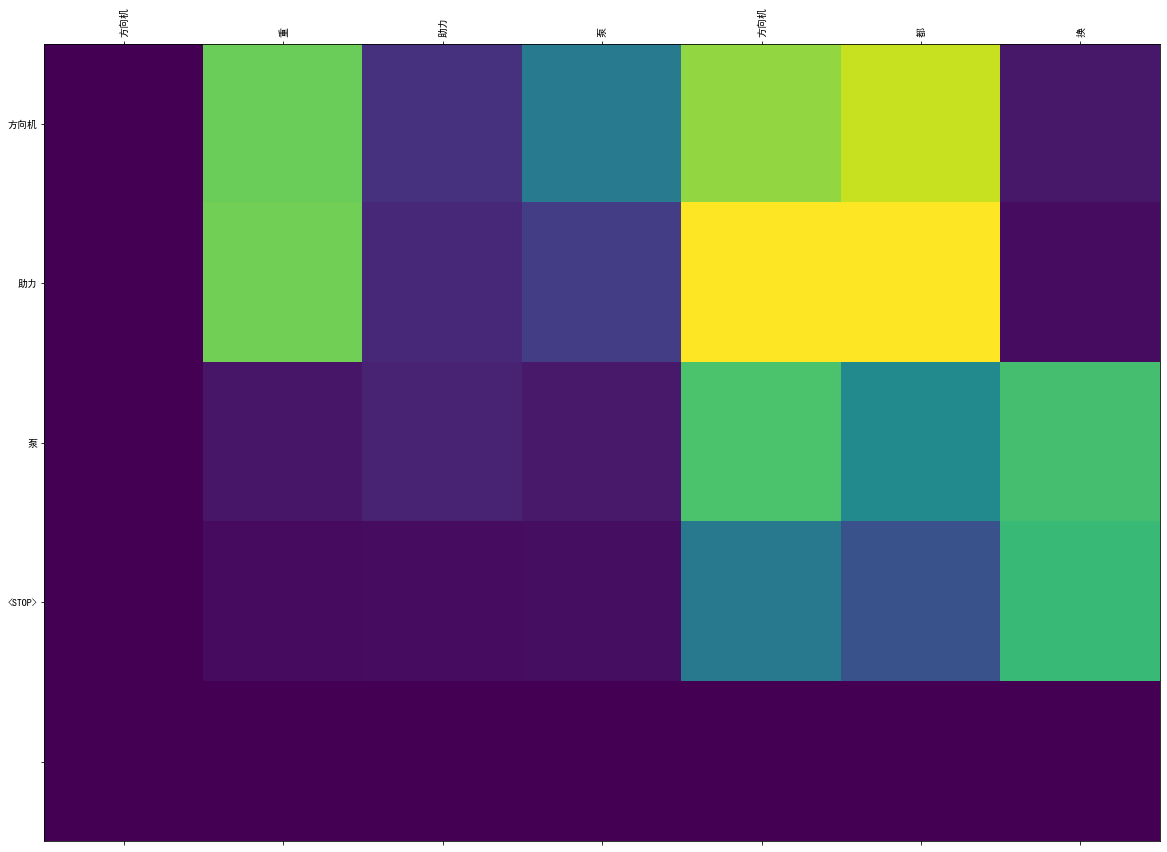

In [23]:
translate(sentence)

In [ ]:
# 下半部分
assert False

In [24]:
def batch_predict(inps):
    # 判断输入长度
    batch_size=len(inps)
    # 开辟结果存储list
    preidicts=[''] * batch_size
    
    inps = tf.convert_to_tensor(inps)
    # 0. 初始化隐藏层输入
    hidden = [tf.zeros((batch_size, params["enc_units"]))]
    # 1. 构建encoder
    enc_output, enc_hidden = model.encoder(inps, hidden)
    # 2. 复制
    dec_hidden = enc_hidden
    # 3. <START> * BATCH_SIZE 
    dec_input = tf.expand_dims([vocab['<START>']] * batch_size, 1)
    
    context_vector, _ = model.attention(dec_hidden, enc_output)
    # Teacher forcing - feeding the target as the next input
    for t in range(params["max_dec_len"]):
        # 计算上下文
        context_vector, attention_weights = model.attention(dec_hidden, enc_output)
        # 单步预测
        predictions, dec_hidden = model.decoder(dec_input,
                                         dec_hidden,
                                         enc_output,
                                         context_vector)
        
        # id转换 贪婪搜索
        predicted_ids = tf.argmax(predictions,axis=1).numpy()
        
        
        for index,predicted_id in enumerate(predicted_ids):
            preidicts[index]+= vocab_reversed[predicted_id] + ' '
        
        # using teacher forcing
        dec_input = tf.expand_dims(predicted_ids, 1)

    results=[]
    for preidict in preidicts:
        # 去掉句子前后空格
        preidict=preidict.strip()
        # 句子小于max len就结束了 截断
        if '<STOP>' in preidict:
            # 截断stop
            preidict=preidict[:preidict.index('<STOP>')]
        # 保存结果
        results.append(preidict)
    return results

In [ ]:
# 测试代码
# ds = iter(dataset)
# x,y = ds.next()
# batch_predict(x)

In [25]:
from tqdm import tqdm
import math

In [26]:
def model_predict(data_X, batch_size):
    # 存储结果
    results=[]
    # 样本数量
    sample_size=len(data_X)
    # batch 操作轮数 math.ceil向上取整 小数 +1
    # 因为最后一个batch可能不足一个batch size 大小 ,但是依然需要计算  
    steps_epoch = math.ceil(sample_size/batch_size)
    # [0,steps_epoch)
    for i in tqdm(range(steps_epoch)):
        batch_data = data_X[i*batch_size:(i+1)*batch_size]
        results+=batch_predict(batch_data)
    return results

In [27]:
%%time
results=model_predict(test_x[:10],batch_size=4)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s]

Wall time: 1.37 s


In [28]:
results

['这种 情况 分析 维修 ',
 '修理厂 进行 抛光 处理 一下 ',
 '更换 喇叭 ',
 '发动机 排气管 漏气 ',
 '描述 情况 下 轮胎 动平衡 问题 导致 ',
 '描述 情况 分析 应该 排气管 滴水 正常 ',
 '防冻液 添加 颜色 添加 颜色 防冻液 颜色 添加 颜色 防冻液 颜色 添加 颜色 防冻液 颜色 添加 颜色 防冻液 颜色 添加 颜色 防冻液 颜色 添加 颜色 防冻液 颜色 添加 颜色 防冻液 颜色 添加 颜色',
 '机油 问题 ',
 '这种 情况 需要 更换 轮胎 花纹 深度 不 影响 车辆 行驶 中 高速行驶 过程 中 轮胎 地面 裂纹 扩散 裂纹 没有 影响 正常 使用 没有 影响 正常 使用 没有 影响 正常 使用 没有',
 '这种 情况 应该 天气 冷 机油 润滑 ']